## Bike Sharing Demand - Machine Learning v.3

- 앞의 v.2에서 casual/registered로 나누는 것보다 `count` 자체에 대해서 예측하는 것이 더 성능이 좋았다.
- 이번에는 count에 대해 예측하되, **season 과 month 변수가 겹치므로 둘 중 하나만 사용했을 때 어떤 것이 더 성능이 좋은지**를 알아보자.

## 1.Load the data
- EDA 편에서 확인한 결과 중복이나 결측치는 없었다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#train data : target은 count 컬럼 
train = pd.read_csv('data/train.csv', parse_dates=['datetime'])
print(train.shape)
train.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
# test data
test = pd.read_csv('data/test.csv', parse_dates=['datetime'])
print(test.shape)
test.head()

(6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


## 2. Preprocessing
#### 1) train data에서 필요한 열을 생성하자.

In [4]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['hour'] = train['datetime'].dt.hour
train['dayofweek'] = train['datetime'].dt.dayofweek

#불필요한 열 삭제
del train['datetime']
#casual, registered 삭제
del train['casual']
del train['registered']

train.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,0,5
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,5
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,2,5


#### 2) weather ==4 아웃라이어 제거(1개 제거됨)

In [5]:
print('제거 전 ', len(train))
train = train.loc[train['weather'] !=4 ]
print('제거 후: ', len(train))

제거 전  10886
제거 후:  10885


#### 3) count 열의 아웃라이어 제거
- 3시그마를 초과하는 경우 제거

In [6]:
train = train[train['count'] - train['count'].mean() < 3*train['count'].std()]
train.reset_index(inplace =True, drop = True)
print(train.shape)
display(train.head())

(10738, 13)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,0,5
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,5
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,2,5
3,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,3,5
4,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,4,5


#### 4)count 변수에 로그변환

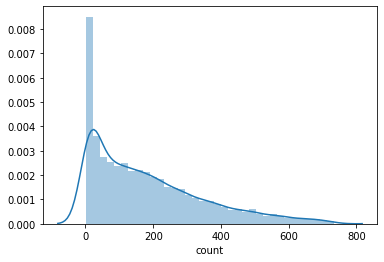

In [7]:
# casual & registered 의 분포 파악
sns.distplot(train['count'])

위의 그래프 모두 왼쪽으로 치우쳐져 있으므로, **로그변환**을 통해 target의 분포를 맞추자.

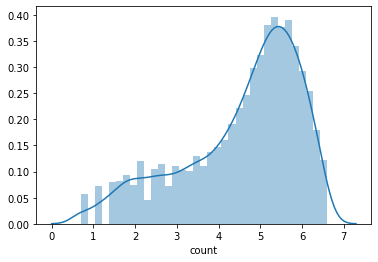

In [8]:
# 로그변환 후 
sns.distplot(np.log1p(train['count']))

완벽한 정규분포 형태는 아니지만, 좀 더 정규분포에 가까워졌으므로 이를 사용하기로 한다!

In [9]:
train['count'] = np.log1p(train['count'])

display(train.head())

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,2.833213,2011,1,0,5
1,1,0,0,1,9.02,13.635,80,0.0,3.713572,2011,1,1,5
2,1,0,0,1,9.02,13.635,80,0.0,3.496508,2011,1,2,5
3,1,0,0,1,9.84,14.395,75,0.0,2.639057,2011,1,3,5
4,1,0,0,1,9.84,14.395,75,0.0,0.693147,2011,1,4,5


In [10]:
# skew(왜도) 확인 : +- 2 범위 안에 들어가므로 치우침이 없다고 볼 수 있음
print(train['count'].skew())

-0.8704448527723871


#### 5) 카테고리 변수 카테고리화

In [11]:
train.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,2.833213,2011,1,0,5
1,1,0,0,1,9.02,13.635,80,0.0,3.713572,2011,1,1,5
2,1,0,0,1,9.02,13.635,80,0.0,3.496508,2011,1,2,5


In [12]:
cate_name = ['weather', 'season', 'year', 'month', 'hour', 'dayofweek', 'holiday', 'workingday']

for c in cate_name:
    train[c] = train[c].astype('category')
train.dtypes

season        category
holiday       category
workingday    category
weather       category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
count          float64
year          category
month         category
hour          category
dayofweek     category
dtype: object

## 3. Modeling

- 참고로 지표 `RMSLE`는 target에 로그변환 시켰기 때문에 그냥 `RMSE`를 쓰면 된다.

In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline

In [14]:
# 1) X, y 나누기
X_df = train.drop(['count'], axis = 1) 
y_df = train['count']

In [15]:
# 2) 변수에서 season, month를 각각 제거
X_df_s = X_df.drop(['month'], axis = 1)
X_df_m = X_df.drop(['season'], axis = 1)

## <season 변수만을 남겼을 때>

#### 선형회귀 및 릿지

In [16]:
from sklearn.preprocessing import RobustScaler
#선형회귀 모델
lr_reg = LinearRegression()
#피처에 대해 표준화 진행과 k-fold를 함께 함
pipe = make_pipeline(RobustScaler(), lr_reg)
scores = cross_validate(pipe, X_df_s, y_df, cv=5, scoring='neg_mean_squared_error',return_train_score=True)
print("MSLE: {0:.3f}".format(np.mean(-scores['test_score']))) #디폴트가 음수라 -를 붙여야 제대로 된 결과가 나옴.

MSLE: 1.056


In [17]:
from sklearn.preprocessing import StandardScaler

#선형회귀 모델
lr_reg = LinearRegression()
#피처에 대해 표준화 진행과 k-fold를 함께 함
pipe = make_pipeline(StandardScaler(), lr_reg)
scores = cross_validate(pipe, X_df_s, y_df, cv=5, scoring='neg_mean_squared_error',return_train_score=True)
print("MSLE: {0:.3f}".format(np.mean(-scores['test_score']))) #디폴트가 음수라 -를 붙여야 제대로 된 결과가 나옴.

MSLE: 1.056


In [18]:
from sklearn.preprocessing import MinMaxScaler

#선형회귀 모델
lr_reg = LinearRegression()
#피처에 대해 표준화 진행과 k-fold를 함께 함
pipe = make_pipeline(MinMaxScaler(), lr_reg)
scores = cross_validate(pipe, X_df_s, y_df, cv=5, scoring='neg_mean_squared_error',return_train_score=True)
print("MSLE: {0:.3f}".format(np.mean(-scores['test_score']))) #디폴트가 음수라 -를 붙여야 제대로 된 결과가 나옴.

MSLE: 1.056


Ridge

In [19]:
#릿지
ridge_reg = Ridge()
pipe = make_pipeline(RobustScaler(), ridge_reg)
scores = cross_validate(ridge_reg, X_df_s, y_df, cv = 5, scoring='neg_mean_squared_error',return_train_score=True)
print("MSLE: {0:.3f}".format(np.mean(-scores['test_score']))) 

MSLE: 1.056


In [20]:
#릿지에 대해 하이퍼 파라미터 튜닝
pipeline = Pipeline([('scaler', MinMaxScaler()), ('ridge',Ridge())])
params={'ridge__alpha':[5, 10, 15, 20]}
grid_model = GridSearchCV(pipeline, param_grid=params, scoring='neg_mean_squared_error', cv=5)
grid_model.fit(X_df_s, y_df)
print("MSLE: {0:.3f}".format( -1*grid_model.best_score_)) 
print('optimal hyperparameter: ', grid_model.best_params_)

MSLE: 1.055
optimal hyperparameter:  {'ridge__alpha': 5}


#### Tree model

In [21]:
#LGBM
lgbm = LGBMRegressor(n_estimators = 500, objective = 'regression')

#피처에 대해 표준화 진행과 k-fold를 함께 함
pipe = make_pipeline(MinMaxScaler(), lgbm)
scores = cross_validate(pipe, X_df_s, y_df, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
print("MSLE: {0:.3f}".format(np.mean(-scores['test_score']))) 

MSLE: 0.183


In [22]:
# estimators 늘려보기
lgbm = LGBMRegressor(n_estimators = 1000, objective = 'regression')

#피처에 대해 표준화 진행과 k-fold를 함께 함
pipe = make_pipeline(MinMaxScaler(), lgbm)
scores = cross_validate(pipe, X_df_s, y_df, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
print("MSLE: {0:.3f}".format(np.mean(-scores['test_score']))) 

MSLE: 0.187


In [23]:
#하이퍼 파라미터 튜닝
pipeline = Pipeline([('scaler', MinMaxScaler()), ('lgbm',LGBMRegressor(objective='regression'))])
params={'lgbm__learning_rate': [0.001, 0.01, 0.1],
       'lgbm__max_depth': [5, 10],
       'lgbm__reg_lambda':[0.1, 1],
       'lgbm__subsample': [0.5, 1],
       'lgbm__n_estimators': [300, 500]}
grid_model = GridSearchCV(pipeline, param_grid=params, scoring='neg_mean_squared_error', cv=5, n_jobs = 5, verbose=True)
grid_model.fit(X_df_s, y_df)
print("MSLE: {0:.3f}".format( -1*grid_model.best_score_)) 
print('optimal hyperparameter: ', grid_model.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   25.0s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:  1.5min finished


MSLE: 0.178
optimal hyperparameter:  {'lgbm__learning_rate': 0.1, 'lgbm__max_depth': 10, 'lgbm__n_estimators': 300, 'lgbm__reg_lambda': 1, 'lgbm__subsample': 0.5}


In [24]:
#하이퍼 파라미터 튜닝
pipeline = Pipeline([('scaler', MinMaxScaler()), ('lgbm',LGBMRegressor(objective='regression', learning_rate = 0.1, subsample = 0.5))])
params={'lgbm__max_depth': [3, 5, 7],
       'lgbm__reg_lambda':[0.1, 1],
       'lgbm__n_estimators': [200, 300]}
grid_model = GridSearchCV(pipeline, param_grid=params, scoring='neg_mean_squared_error', cv=5, n_jobs = 5, verbose=True)
grid_model.fit(X_df_s, y_df)
print("MSLE: {0:.3f}".format( -1*grid_model.best_score_)) 
print('optimal hyperparameter: ', grid_model.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.9s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:   10.2s finished


MSLE: 0.174
optimal hyperparameter:  {'lgbm__max_depth': 7, 'lgbm__n_estimators': 200, 'lgbm__reg_lambda': 1}


## 4-1. Predict Test data (season 변수)
만들어진 모델을 바탕으로 test data에 대해 예측해보자.

In [25]:
X_df_s.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,2011,0,5
1,1,0,0,1,9.02,13.635,80,0.0,2011,1,5
2,1,0,0,1,9.02,13.635,80,0.0,2011,2,5
3,1,0,0,1,9.84,14.395,75,0.0,2011,3,5
4,1,0,0,1,9.84,14.395,75,0.0,2011,4,5


In [26]:
# test data를 train처럼 가공
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [27]:
# 필요 변수 생성 - month는 삭제
test['year'] = test['datetime'].dt.year
test['hour'] = test['datetime'].dt.hour
test['dayofweek'] = test['datetime'].dt.dayofweek
#datetime 삭제
del test['datetime']

test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek
0,1,0,1,1,10.66,11.365,56,26.0027,2011,0,3
1,1,0,1,1,10.66,13.635,56,0.0000,2011,1,3
2,1,0,1,1,10.66,13.635,56,0.0000,2011,2,3
3,1,0,1,1,10.66,12.880,56,11.0014,2011,3,3
4,1,0,1,1,10.66,12.880,56,11.0014,2011,4,3


In [28]:
#카테고리 변수 생성
cate_name = ['weather', 'season', 'year', 'hour','dayofweek', 'holiday', 'workingday']

for c in cate_name:
    test[c] = test[c].astype('category')
test.dtypes

season        category
holiday       category
workingday    category
weather       category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
year          category
hour          category
dayofweek     category
dtype: object

### count 예측하기
- 사용 모델: `LGBM`

In [29]:
# 피처 표준화
minmax = MinMaxScaler()
minmax.fit(X_df_s) #훈련셋 모수 분포 저장
X_df_scaled1 = minmax.transform(X_df_s)
X_test_scaled1 = minmax.transform(test)

In [30]:
# 최종 파라미터 튜닝된 모델로 학습 
lgbm = LGBMRegressor(n_estimators = 200, objective = 'regression',
                    learning_rate = 0.1, max_depth = 7, reg_lambda = 1, subsample = 0.5, random_state = 99)

# 학습
lgbm.fit(X_df_scaled1, y_df)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=7,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=99, reg_alpha=0.0,
              reg_lambda=1, silent=True, subsample=0.5,
              subsample_for_bin=200000, subsample_freq=0)

In [31]:
# test에 대해 예측
pred = lgbm.predict(X_test_scaled1)
fpred = np.expm1(pred) #로그변환 값을 풀어줌

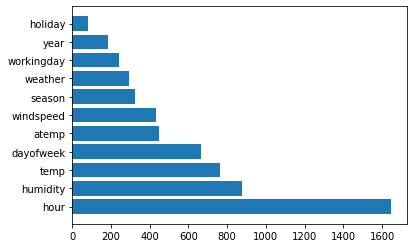

In [32]:
#lgbm 모델의 feature importance
imp = pd.DataFrame({'feature': test.columns, 
                                    'coefficient': lgbm.feature_importances_})
imp = imp.sort_values(by = 'coefficient', ascending = False)

plt.barh(imp['feature'], imp['coefficient'])
plt.show()

In [33]:
imp

,feature,coefficient
9,hour,1646
6,humidity,878
4,temp,764
10,dayofweek,665
5,atemp,449
7,windspeed,433
0,season,325
3,weather,291
2,workingday,241
8,year,185


In [34]:
test['count'] = fpred
test.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,count
0,1,0,1,1,10.66,11.365,56,26.0027,2011,0,3,11.734914
1,1,0,1,1,10.66,13.635,56,0.0000,2011,1,3,4.628953
2,1,0,1,1,10.66,13.635,56,0.0000,2011,2,3,2.820502


In [35]:
# submission 가져오기 
sub = pd.read_csv('data/sampleSubmission.csv')
sub.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [36]:
del sub['count']

In [37]:
sub['count'] = test['count']
sub.head()

,datetime,count
0,2011-01-20 00:00:00,11.734914
1,2011-01-20 01:00:00,4.628953
2,2011-01-20 02:00:00,2.820502
3,2011-01-20 03:00:00,2.067833
4,2011-01-20 04:00:00,1.768152


In [38]:
sub.to_csv('Submission_sy_2-1.csv', index=False)

#### 최종 제출 결과: `Score: 0.37992`
지금까지 한 것 중 최고 성능! 약 110등.

## <month 변수만을 남겼을 때>

In [39]:
from sklearn.preprocessing import MinMaxScaler

#선형회귀 모델
lr_reg = LinearRegression()
#피처에 대해 표준화 진행과 k-fold를 함께 함
pipe = make_pipeline(MinMaxScaler(), lr_reg)
scores = cross_validate(pipe, X_df_m, y_df, cv=5, scoring='neg_mean_squared_error',return_train_score=True)
print("MSLE: {0:.3f}".format(np.mean(-scores['test_score']))) #디폴트가 음수라 -를 붙여야 제대로 된 결과가 나옴.

MSLE: 1.050


In [40]:
#릿지
ridge_reg = Ridge()
pipe = make_pipeline(RobustScaler(), ridge_reg)
scores = cross_validate(ridge_reg, X_df_m, y_df, cv = 5, scoring='neg_mean_squared_error',return_train_score=True)
print("MSLE: {0:.3f}".format(np.mean(-scores['test_score']))) 

MSLE: 1.050


In [41]:
#릿지에 대해 하이퍼 파라미터 튜닝
pipeline = Pipeline([('scaler', MinMaxScaler()), ('ridge',Ridge())])
params={'ridge__alpha':[5, 10, 15, 20]}
grid_model = GridSearchCV(pipeline, param_grid=params, scoring='neg_mean_squared_error', cv=5)
grid_model.fit(X_df_m, y_df)
print("MSLE: {0:.3f}".format( -1*grid_model.best_score_)) 
print('optimal hyperparameter: ', grid_model.best_params_)

MSLE: 1.048
optimal hyperparameter:  {'ridge__alpha': 5}


#### Tree model

In [42]:
#LGBM
lgbm = LGBMRegressor(n_estimators = 500, objective = 'regression')

#피처에 대해 표준화 진행과 k-fold를 함께 함
pipe = make_pipeline(MinMaxScaler(), lgbm)
scores = cross_validate(pipe, X_df_m, y_df, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
print("MSLE: {0:.3f}".format(np.mean(-scores['test_score']))) 

MSLE: 0.185


In [43]:
# estimators 늘려보기
lgbm = LGBMRegressor(n_estimators = 1000, objective = 'regression')

#피처에 대해 표준화 진행과 k-fold를 함께 함
pipe = make_pipeline(MinMaxScaler(), lgbm)
scores = cross_validate(pipe, X_df_m, y_df, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
print("MSLE: {0:.3f}".format(np.mean(-scores['test_score']))) 

MSLE: 0.190


In [44]:
#하이퍼 파라미터 튜닝
pipeline = Pipeline([('scaler', MinMaxScaler()), ('lgbm',LGBMRegressor(objective='regression'))])
params={'lgbm__learning_rate': [0.001, 0.01, 0.1],
       'lgbm__max_depth': [5, 10],
       'lgbm__reg_lambda':[0.1, 1],
       'lgbm__subsample': [0.5, 1],
       'lgbm__n_estimators': [300, 500]}
grid_model = GridSearchCV(pipeline, param_grid=params, scoring='neg_mean_squared_error', cv=5, n_jobs = 5, verbose=True)
grid_model.fit(X_df_m, y_df)
print("MSLE: {0:.3f}".format( -1*grid_model.best_score_)) 
print('optimal hyperparameter: ', grid_model.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   12.9s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.1min
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:  1.4min finished


MSLE: 0.176
optimal hyperparameter:  {'lgbm__learning_rate': 0.1, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 300, 'lgbm__reg_lambda': 1, 'lgbm__subsample': 0.5}


In [45]:
#하이퍼 파라미터 튜닝
pipeline = Pipeline([('scaler', MinMaxScaler()), ('lgbm',LGBMRegressor(objective='regression', learning_rate = 0.1, subsample = 0.5))])
params={'lgbm__max_depth': [3, 5, 7],
       'lgbm__reg_lambda':[0.1, 1],
       'lgbm__n_estimators': [200, 300]}
grid_model = GridSearchCV(pipeline, param_grid=params, scoring='neg_mean_squared_error', cv=5, n_jobs = 5, verbose=True)
grid_model.fit(X_df_m, y_df)
print("MSLE: {0:.3f}".format( -1*grid_model.best_score_)) 
print('optimal hyperparameter: ', grid_model.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.6s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:   11.1s finished


MSLE: 0.174
optimal hyperparameter:  {'lgbm__max_depth': 3, 'lgbm__n_estimators': 300, 'lgbm__reg_lambda': 0.1}


## 4-1. Predict Test data (month 변수)
만들어진 모델을 바탕으로 test data에 대해 예측해보자.

In [46]:
X_df_m.head(3)

,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,hour,dayofweek
0,0,0,1,9.84,14.395,81,0.0,2011,1,0,5
1,0,0,1,9.02,13.635,80,0.0,2011,1,1,5
2,0,0,1,9.02,13.635,80,0.0,2011,1,2,5


In [47]:
# test data 다시 불러오기
test = pd.read_csv('data/test.csv', parse_dates=['datetime'])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [48]:
# 필요 변수 생성
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['hour'] = test['datetime'].dt.hour
test['dayofweek'] = test['datetime'].dt.dayofweek

#datetime, season 삭제
del test['datetime']
del test['season']

test.head(3)

,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,hour,dayofweek
0,0,1,1,10.66,11.365,56,26.0027,2011,1,0,3
1,0,1,1,10.66,13.635,56,0.0000,2011,1,1,3
2,0,1,1,10.66,13.635,56,0.0000,2011,1,2,3


In [49]:
#카테고리 변수 생성
cate_name = ['weather', 'month', 'year', 'hour','dayofweek', 'holiday', 'workingday']

for c in cate_name:
    test[c] = test[c].astype('category')
test.dtypes

holiday       category
workingday    category
weather       category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
year          category
month         category
hour          category
dayofweek     category
dtype: object

### count 예측하기

In [50]:
# 피처 표준화
minmax = MinMaxScaler()
minmax.fit(X_df_m) #훈련셋 모수 분포 저장
X_df_scaled2 = minmax.transform(X_df_m)
X_test_scaled2 = minmax.transform(test)

In [51]:
# 최종 파라미터 튜닝된 모델로 학습 
lgbm = LGBMRegressor(n_estimators = 300, objective = 'regression',
                    learning_rate = 0.1, max_depth = 3, reg_lambda = 0.1, subsample = 0.5, random_state = 99)

# 학습
lgbm.fit(X_df_scaled2, y_df)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=3,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=300, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=99, reg_alpha=0.0,
              reg_lambda=0.1, silent=True, subsample=0.5,
              subsample_for_bin=200000, subsample_freq=0)

In [52]:
# test에 대해 예측
pred = lgbm.predict(X_test_scaled2)
fpred = np.expm1(pred) #로그변환 값을 풀어줌

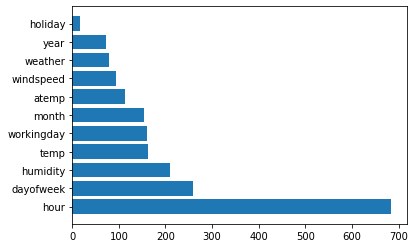

In [53]:
#lgbm 모델의 feature importance
imp = pd.DataFrame({'feature': test.columns, 
                                    'coefficient': lgbm.feature_importances_})
imp = imp.sort_values(by = 'coefficient', ascending = False)

plt.barh(imp['feature'], imp['coefficient'])
plt.show()

In [54]:
test['count'] = fpred
test.head(3)

,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,hour,dayofweek,count
0,0,1,1,10.66,11.365,56,26.0027,2011,1,0,3,7.580797
1,0,1,1,10.66,13.635,56,0.0000,2011,1,1,3,4.308976
2,0,1,1,10.66,13.635,56,0.0000,2011,1,2,3,2.601890


In [55]:
# submission 가져오기 
sub = pd.read_csv('data/sampleSubmission.csv')
sub.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [56]:
del sub['count']

In [57]:
sub['count'] = test['count']
sub.head()

,datetime,count
0,2011-01-20 00:00:00,7.580797
1,2011-01-20 01:00:00,4.308976
2,2011-01-20 02:00:00,2.601890
3,2011-01-20 03:00:00,1.668404
4,2011-01-20 04:00:00,1.574208


In [58]:
sub.to_csv('Submission_sy_2-2.csv', index=False)

#### 최종 제출 결과: `Score: 0.43700`
지금까지 한 것 중 성능이 가장 안좋았다.  
k-fold로 val set에 대해 예측했을 땐 season만 남기든, month만 남기든 RMLSE가 `0.174`로 동일했는데,  
test set에 대해 예측해보니 성능 차이가 꽤 많이 난다. month가 너무 세부적으로 나뉜 값이라 과적합이 된 듯.